##Auto encoding


In [11]:
from Tumor_Classifier_Utils import *

In [12]:
data_train = scio.loadmat('Data/tumor_train_data_32.mat')
data_val = scio.loadmat('Data/tumor_val_data_32.mat')
data_test = scio.loadmat('Data/tumor_test_data_32.mat')

N = 32 # image dimensions (N x N after preprocessing)
num_classes = 4; # how many different types of classifications we have 

x_train = np.transpose(data_train['img_train'], (2, 0, 1)).reshape(-1, N, N, 1)
y_train = data_train['labels_train']
x_val = np.transpose(data_val['img_val'], (2, 0, 1)).reshape(-1, N, N, 1)
y_val = data_val['labels_val']
x_test = np.transpose(data_test['img_test'], (2, 0, 1)).reshape(-1, N, N, 1)
y_test = data_test['labels_test']


print(x_train.shape)
print(x_test.shape)
print(x_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(2500, 32, 32, 1)
(264, 32, 32, 1)
(500, 32, 32, 1)
(2500, 1)
(264, 1)
(500, 1)


In [13]:
print(type(x_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


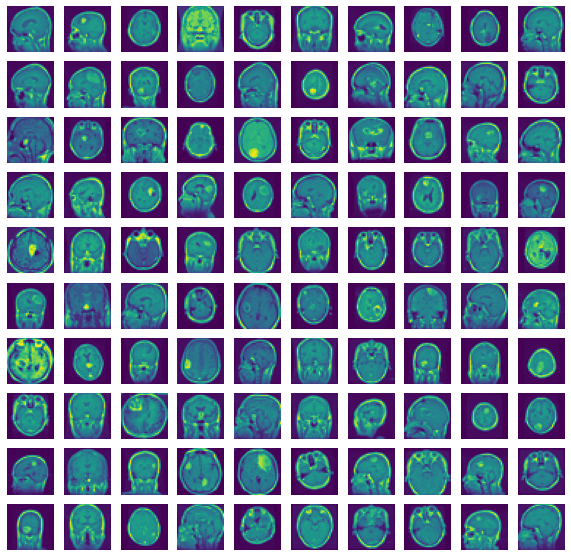

In [14]:
fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(x_train[i,:,:,0])
    ax.axis('off')

In [44]:
input_img = layers.Input(shape=(N, N, 1))
# encoder
# final conv2d, batch norm and spatial dropout
x = layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(input_img) # consider using alternate activation
x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation=None)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2,2)(x)
x = layers.Activation('relu')(x)

x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x) # consider using alternate activation
x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation=None)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2,2)(x)
x = layers.Activation('relu')(x)

# compressed representation bottleneck
encoded = layers.MaxPooling2D((2, 2), padding='same', name='bottleneck')(x)

# neural net (dense layers) (classifier)
x = layers.Flatten()(encoded)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
class_output= layers.Dense(num_classes, activation='softmax')(x)

# decoder
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same', name='autoencoder_output')(x)

autoEncoder = keras.Model(input_img, {'ae': decoded, 'class' : class_output})

In [45]:
encoded = keras.Model(input_img,encoded)
decoder_layer = autoEncoder.layers[-1]
decoder = keras.Model(input_img, decoder_layer(input_img))

In [46]:
autoEncoder.compile(optimizer='adam', loss={'ae' : 'mean_squared_error', 'class' : tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)})
print(autoEncoder.summary())
keras.utils.plot_model(autoEncoder, show_shapes=True)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_37 (Conv2D)             (None, 32, 32, 64)   640         ['input_7[0][0]']                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 32, 32, 32)   18464       ['conv2d_37[0][0]']              
                                                                                                  
 batch_normalization_10 (BatchN  (None, 32, 32, 32)  128         ['conv2d_38[0][0]']              
 ormalization)                                                                              

In [47]:
history = autoEncoder.fit(x_train, {'ae' : x_train, 'class' : y_train},
                    batch_size=128,
                    epochs=40,
                    validation_data=(x_val, {'ae' : x_val, 'class' : y_val} ), verbose = False)

loss
autoencoder_output_loss
dense_17_loss
val_loss
val_autoencoder_output_loss
val_dense_17_loss


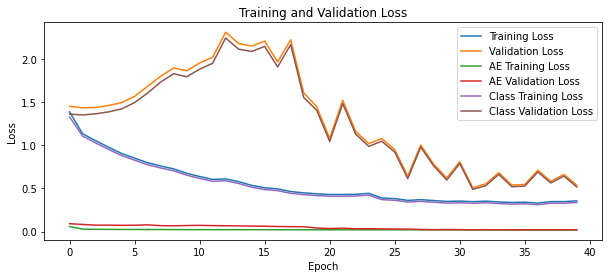

In [53]:
for value in history.history:
    print(value)

def plot_history(history):
    plt.figure(figsize=(10, 4))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.plot(history['autoencoder_output_loss'], label='AE Training Loss')
    plt.plot(history['val_autoencoder_output_loss'], label='AE Validation Loss')
    plt.plot(history['dense_17_loss'], label='Class Training Loss')
    plt.plot(history['val_dense_17_loss'], label='Class Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plot_history(history.history)

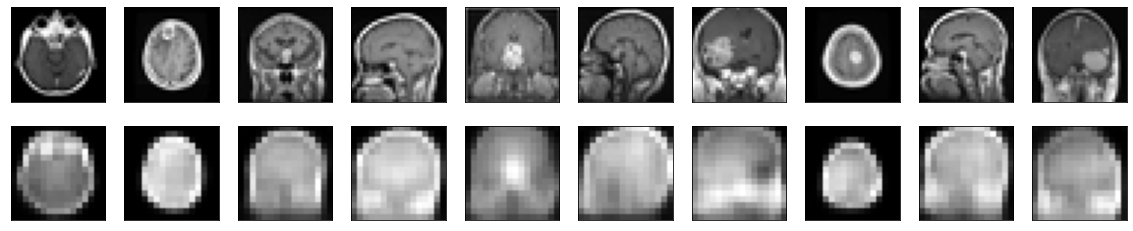

In [54]:
decoded_imgs = autoEncoder.predict(x_test)['ae']

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [55]:
bottleneck_output = autoEncoder.get_layer('bottleneck').output 
bottleneck_output = layers.Flatten()(bottleneck_output)
bottleneck_model = keras.Model(inputs = autoEncoder.input, outputs = bottleneck_output)
bottleneck_model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_37 (Conv2D)          (None, 32, 32, 64)        640       
                                                                 
 conv2d_38 (Conv2D)          (None, 32, 32, 32)        18464     
                                                                 
 batch_normalization_10 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 activation_10 (Activation)  (None, 16, 16, 32)        0  

In [56]:
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])

    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax)
    pred = model.predict(X_train)
    matches = (pred == Y_train.reshape(-1))
#    matches = (pred == Y_train).numpy()
    conf.ax_.set_title('Training Set Performance: %s' % (sum(matches)/len(matches)));

    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    pred = model.predict(X_test)
    matches = (pred == Y_test.reshape(-1))
#    matches = (pred == Y_test).numpy()
    conf.ax_.set_title('Test Set Performance: %s' % (sum(matches)/len(matches)));  

(2500, 32, 32, 1)
(2500, 256)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


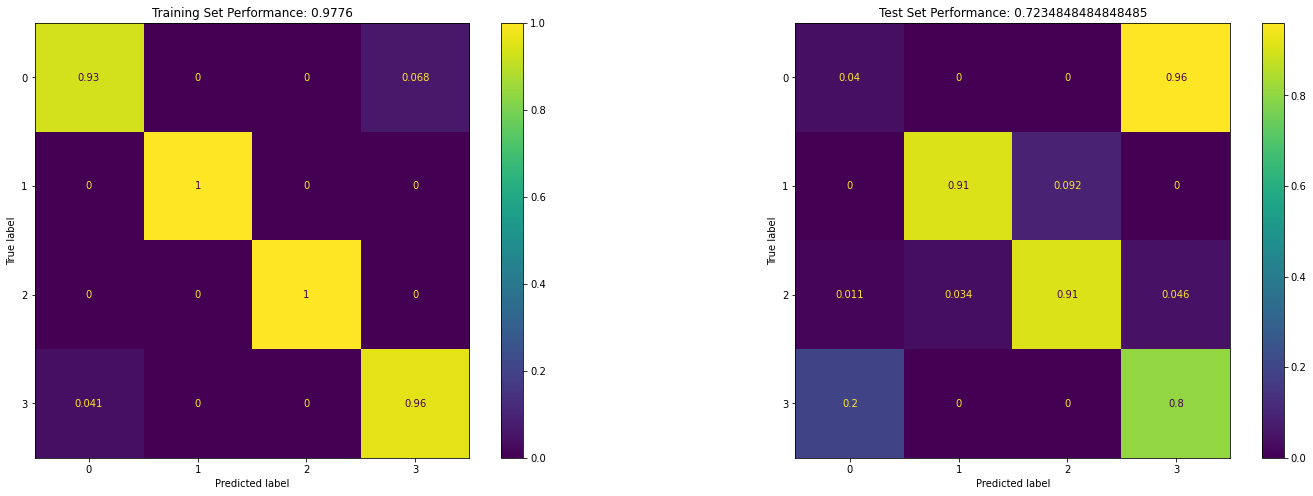

In [57]:
print(x_train.shape)
train_ae_feat = bottleneck_model.predict(x_train)
print(train_ae_feat.shape)
test_ae_feat = bottleneck_model.predict(x_test)

cknn = KNeighborsClassifier(n_neighbors=1, weights='distance').fit(train_ae_feat, y_train)
eval_model(cknn, train_ae_feat, y_train, test_ae_feat, y_test)